# Lead Scoring Case Study 

- Supervised Learning Algorithm - Logistic Regression [ Classification ]
- Programming Language - Python
- Developed by UV, VK, VY


## Initialization - Preprocessing - Visualization

### 1. Package Imports and Data Initialization

In [1]:
# import all libraries numpy, pandas, matplotlib, seaborn. 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplib
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Import the necessary machine learning packages (sklearn, statsmodel) for performing logistic regression
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve

In [3]:
# Import the dataset from leads.csv
lead_score_df = pd.read_csv('Leads.csv')
lead_score_df.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No,No,Modified


In [4]:
lead_score_df.Tags.value_counts()

Tags
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to O

###  ----------------------------------------------------------------------

### 2. Data Preprocesing - Part 1

#### Custom Functions for Preprocessing and EDA

In [4]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df, cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            if not isinstance(df[col][df[col].notna()].unique()[0], str):
                d_categories['float_ts'].append(col)
            else:
                d_categories['int_cat'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
 
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(12), labels=df[col].value_counts().head(12).index.str[:10], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False, )
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().head(15).index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:10], y=target, order=df[col].value_counts().index.str[:10], palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=90); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show();
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict(marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

#### Data Cleaning, Column Renaming, Missing Value Imputation, Feature Selection

In [5]:
#duplicates row validation by id cols
print(f"{lead_score_df.index.is_unique}, {lead_score_df.columns.is_unique}, {lead_score_df['Prospect ID'].is_unique}, {lead_score_df['Lead Number'].is_unique}")

True, True, True, True


In [6]:
# drop unnecessary columns
lead_score_df = lead_score_df.drop(columns=['Prospect ID', 'I agree to pay the amount through cheque','Lead Number', 'Last Notable Activity'])

In [7]:
# rename columns that are too long
lead_score_df = lead_score_df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [8]:
# replace unnecessary space in columns with underscore and covert it to lower case
lead_score_df.columns = lead_score_df.columns.str.replace(pat=' ',repl='_', regex=True)
lead_score_df.columns = lead_score_df.columns.str.lower()

In [9]:
# Check the shape and size of the data frame
lead_score_df.head(1)
lead_score_df.dtypes
print(f'{lead_score_df.shape}, {lead_score_df.size}')

,lead_origin,lead_source,do_not_email,do_not_call,converted,totalvisits,ttime_on_site,pg_view_pv,last_activity,country,specialization,info_abt_x_edu,curr_occupation,reason_behind_course,search,magazine,newspaper_article,x_education_forums,newspaper,digital_advertisement,through_recommendations,more_course_updates,tags,lead_quality,supply_chain_info,get_dm,lead_profile,city,asym_activ_idx,asym_prof_idx,asym_activ_score,asym_prof_score,avail_free_copy
0,API,Olark Chat,No,No,0,0.000,0,0.000,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.000,15.000,No


lead_origin                 object
lead_source                 object
do_not_email                object
do_not_call                 object
converted                    int64
totalvisits                float64
ttime_on_site                int64
pg_view_pv                 float64
last_activity               object
country                     object
specialization              object
info_abt_x_edu              object
curr_occupation             object
reason_behind_course        object
search                      object
magazine                    object
newspaper_article           object
x_education_forums          object
newspaper                   object
digital_advertisement       object
through_recommendations     object
more_course_updates         object
tags                        object
lead_quality                object
supply_chain_info           object
get_dm                      object
lead_profile                object
city                        object
asym_activ_idx      

(9240, 33), 304920


In [10]:
# check null val percentage
# After checking the null value percentage for all the features
# We could see that there are many features that have more than 45% of non values

check_cols_null_pct(lead_score_df)

lead_quality              51.591
asym_prof_score           45.649
asym_activ_score          45.649
asym_prof_idx             45.649
asym_activ_idx            45.649
tags                      36.288
lead_profile              29.318
reason_behind_course      29.318
curr_occupation           29.113
country                   26.634
info_abt_x_edu            23.885
specialization            15.563
city                      15.368
pg_view_pv                 1.483
totalvisits                1.483
last_activity              1.115
lead_source                0.390
more_course_updates        0.000
get_dm                     0.000
supply_chain_info          0.000
lead_origin                0.000
newspaper_article          0.000
through_recommendations    0.000
digital_advertisement      0.000
newspaper                  0.000
x_education_forums         0.000
magazine                   0.000
search                     0.000
ttime_on_site              0.000
converted                  0.000
do_not_cal

In [11]:
# replace select string with nan
lead_score_df = lead_score_df.replace(to_replace=['select','Select'], value=np.nan)

# validate select str is replaced
[i for i in lead_score_df.columns if 'select' in (lead_score_df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]

[]

##### Constant Feature Identification

In [12]:
# check constant features that has only one values
# In the given data set there are a lot of features that have only single value as a category
# These are called as constant features and these features are of little relevance for the machine learning model hence we dropped those features
 
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(lead_score_df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

ModuleNotFoundError: No module named 'fast_ml'

#####

In [13]:
# drop all the constant_features 
lead_score_df = lead_score_df.drop(['magazine', 'more_course_updates', 'supply_chain_info', 'get_dm', 'x_education_forums', 
                                    'newspaper', 'do_not_call', 'newspaper_article', 'digital_advertisement', 'through_recommendations', 'search'], axis=1)

In [14]:
# convert dtypes
# Convert the data type of certain features from object to category type

obj_cols = lead_score_df.select_dtypes(include='object').columns
lead_score_df[obj_cols] = lead_score_df[obj_cols].astype(dtype='category')

In [15]:
# check null val percentage
# Since we have replaced select as null value for certain columns we are seeing increase in the null value percentage for those features
# Therefore we dropped all the features that have more than 40 of null values

null_pct = check_cols_null_pct(lead_score_df)
null_pct
lead_score_df = lead_score_df.drop(null_pct[null_pct > 40].index, axis=1)

info_abt_x_edu         78.463
lead_profile           74.188
lead_quality           51.591
asym_prof_score        45.649
asym_activ_score       45.649
asym_prof_idx          45.649
asym_activ_idx         45.649
city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
pg_view_pv              1.483
totalvisits             1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
ttime_on_site           0.000
converted               0.000
do_not_email            0.000
avail_free_copy         0.000
dtype: float64

In [16]:
null_pct = check_cols_null_pct(lead_score_df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols
# below are the columns rest after dropping the all columns having missing value more than 40%

city                   39.708
specialization         36.580
tags                   36.288
reason_behind_course   29.318
curr_occupation        29.113
country                26.634
totalvisits             1.483
pg_view_pv              1.483
last_activity           1.115
lead_source             0.390
lead_origin             0.000
do_not_email            0.000
converted               0.000
ttime_on_site           0.000
avail_free_copy         0.000
dtype: float64

Index(['city', 'specialization', 'tags', 'reason_behind_course',
       'curr_occupation', 'country', 'totalvisits', 'pg_view_pv',
       'last_activity', 'lead_source'],
      dtype='object')

In [17]:
lead_score_df = lead_score_df.drop('country',axis=1)
# dropping the country column now because it has not much input

In [18]:
lead_score_df.columns

Index(['lead_origin', 'lead_source', 'do_not_email', 'converted',
       'totalvisits', 'ttime_on_site', 'pg_view_pv', 'last_activity',
       'specialization', 'curr_occupation', 'reason_behind_course', 'tags',
       'city', 'avail_free_copy'],
      dtype='object')

In [19]:
lead_score_df.describe(include=np.number)
lead_score_df.describe(exclude=np.number)
# this line of code will show the all things of the column of lead_score_df remaining 

,converted,totalvisits,ttime_on_site,pg_view_pv
count,9240.000,9103.000,9240.000,9103.000
mean,0.385,3.445,487.698,2.363
std,0.487,4.855,548.021,2.161
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,12.000,1.000
50%,0.000,3.000,248.000,2.000
75%,1.000,5.000,936.000,3.000
max,1.000,251.000,2272.000,55.000


,lead_origin,lead_source,do_not_email,last_activity,specialization,curr_occupation,reason_behind_course,tags,city,avail_free_copy
count,9240,9204,9240,9137,5860,6550,6531,5887,5571,9240
unique,5,21,2,17,18,6,3,26,6,2
top,Landing Page Submission,Google,No,Email Opened,Finance Management,Unemployed,Better Career Prospects,Will revert after reading the email,Mumbai,No
freq,4886,2868,8506,3437,976,5600,6528,2072,3222,6352


In [20]:
lead_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   lead_origin           9240 non-null   category
 1   lead_source           9204 non-null   category
 2   do_not_email          9240 non-null   category
 3   converted             9240 non-null   int64   
 4   totalvisits           9103 non-null   float64 
 5   ttime_on_site         9240 non-null   int64   
 6   pg_view_pv            9103 non-null   float64 
 7   last_activity         9137 non-null   category
 8   specialization        5860 non-null   category
 9   curr_occupation       6550 non-null   category
 10  reason_behind_course  6531 non-null   category
 11  tags                  5887 non-null   category
 12  city                  5571 non-null   category
 13  avail_free_copy       9240 non-null   category
dtypes: category(10), float64(2), int64(2)
memory usage: 383.

In [21]:
# trying to remove the rows from totalvisits, pg_view_pv, last_activity and lead_source
lead_score_df.dropna(subset=['totalvisits'], inplace=True)
lead_score_df.dropna(subset=['pg_view_pv'], inplace=True)
lead_score_df.dropna(subset=['last_activity'], inplace=True)
lead_score_df.dropna(subset=['lead_source'], inplace=True)

In [24]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%  
for i in lead_score_df.select_dtypes(include='category'):
    temp = lead_score_df[i].value_counts(normalize=True, ascending=False) * 100
    if temp.iloc[0] > 50:
        lead_score_df[i] = lead_score_df[i].fillna(temp.index[0])

In [26]:
# Now there are only two columns that have more than 36 off missing values tags and specialization

null_pct = check_cols_null_pct(lead_score_df)
null_pct[null_pct > 0]

tags             36.665
specialization   36.169
dtype: float64

In [27]:
lead_score_df.dtypes

lead_origin             category
lead_source             category
do_not_email            category
converted                  int64
totalvisits              float64
ttime_on_site              int64
pg_view_pv               float64
last_activity           category
specialization          category
curr_occupation         category
reason_behind_course    category
tags                    category
city                    category
avail_free_copy         category
dtype: object

In [28]:
lead_score_df.specialization.value_counts()

specialization
Finance Management                   959
Human Resource Management            837
Marketing Management                 823
Operations Management                499
Business Administration              399
IT Projects Management               366
Supply Chain Management              346
Banking, Investment And Insurance    335
Media and Advertising                202
Travel and Tourism                   202
International Business               176
Healthcare Management                156
Hospitality Management               111
E-COMMERCE                           111
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: count, dtype: int64

In [29]:
lead_score_df.tags.value_counts()

tags
Will revert after reading the email                  2016
Ringing                                              1187
Interested in other courses                           509
Already a student                                     465
Closed by Horizzon                                    301
switched off                                          240
Busy                                                  185
Lost to EINS                                          172
Not doing further education                           145
Interested  in full time MBA                          116
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    25
in touch with EINS                                     12
Lost to O

###  ----------------------------------------------------------------------

### 3. Data Visualization - EDA

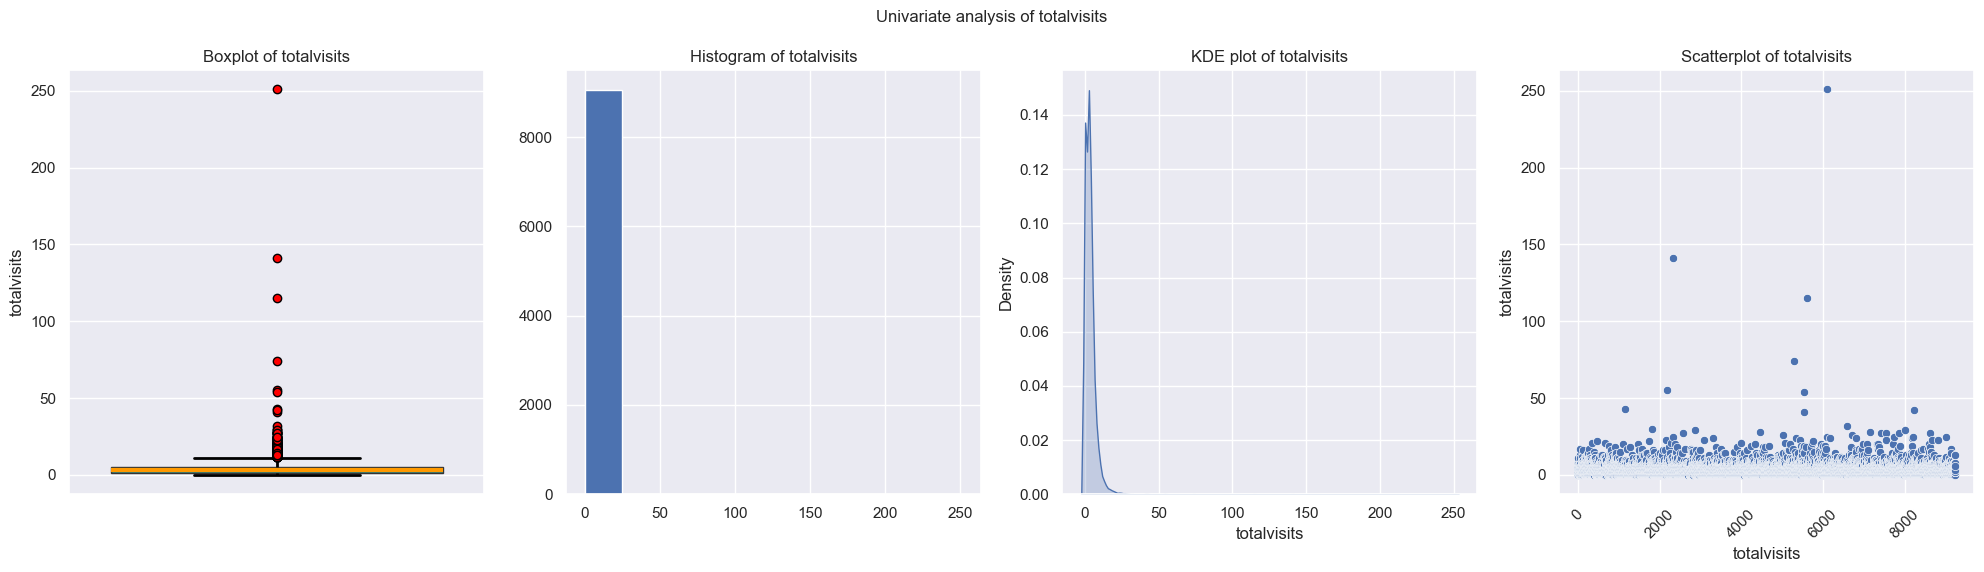

<Figure size 640x480 with 0 Axes>

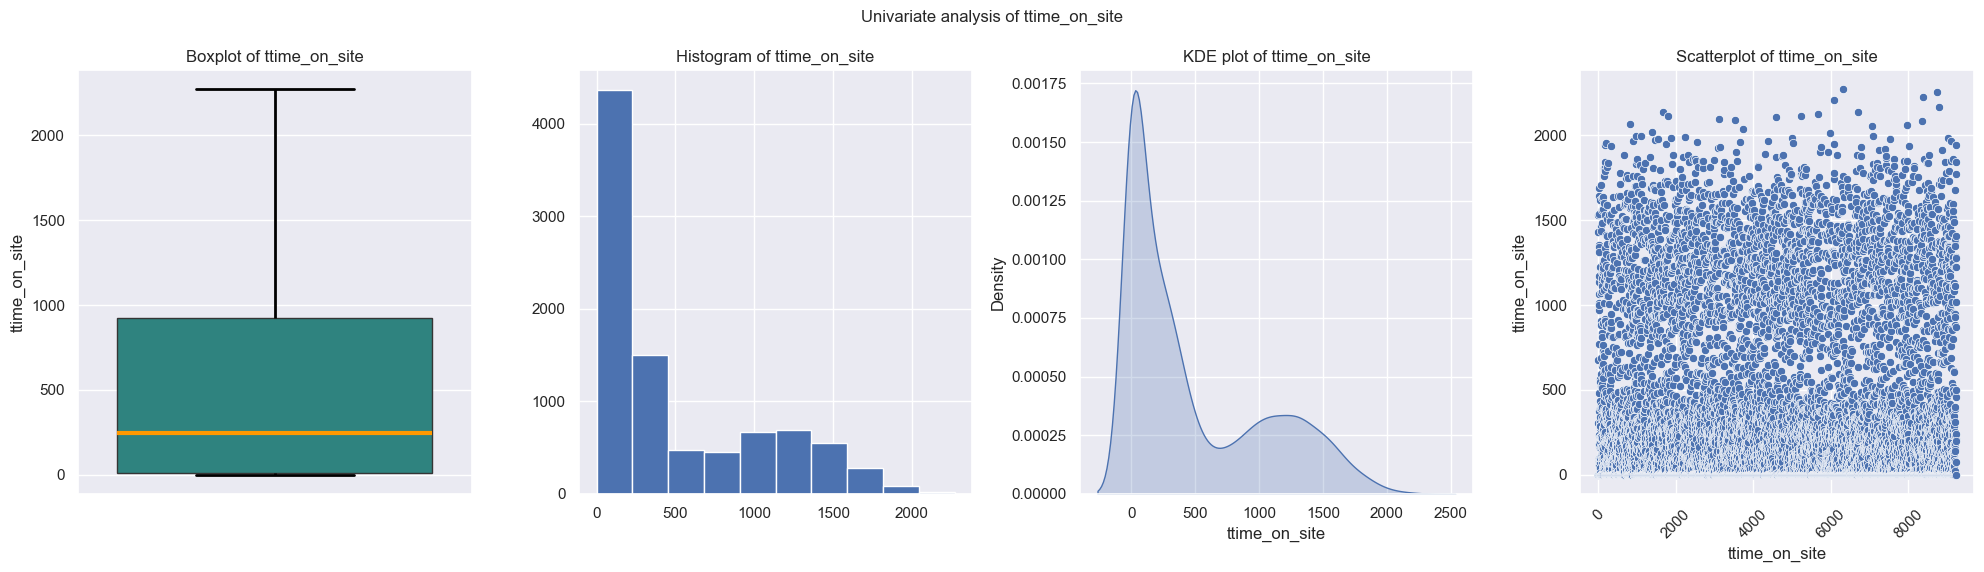

<Figure size 640x480 with 0 Axes>

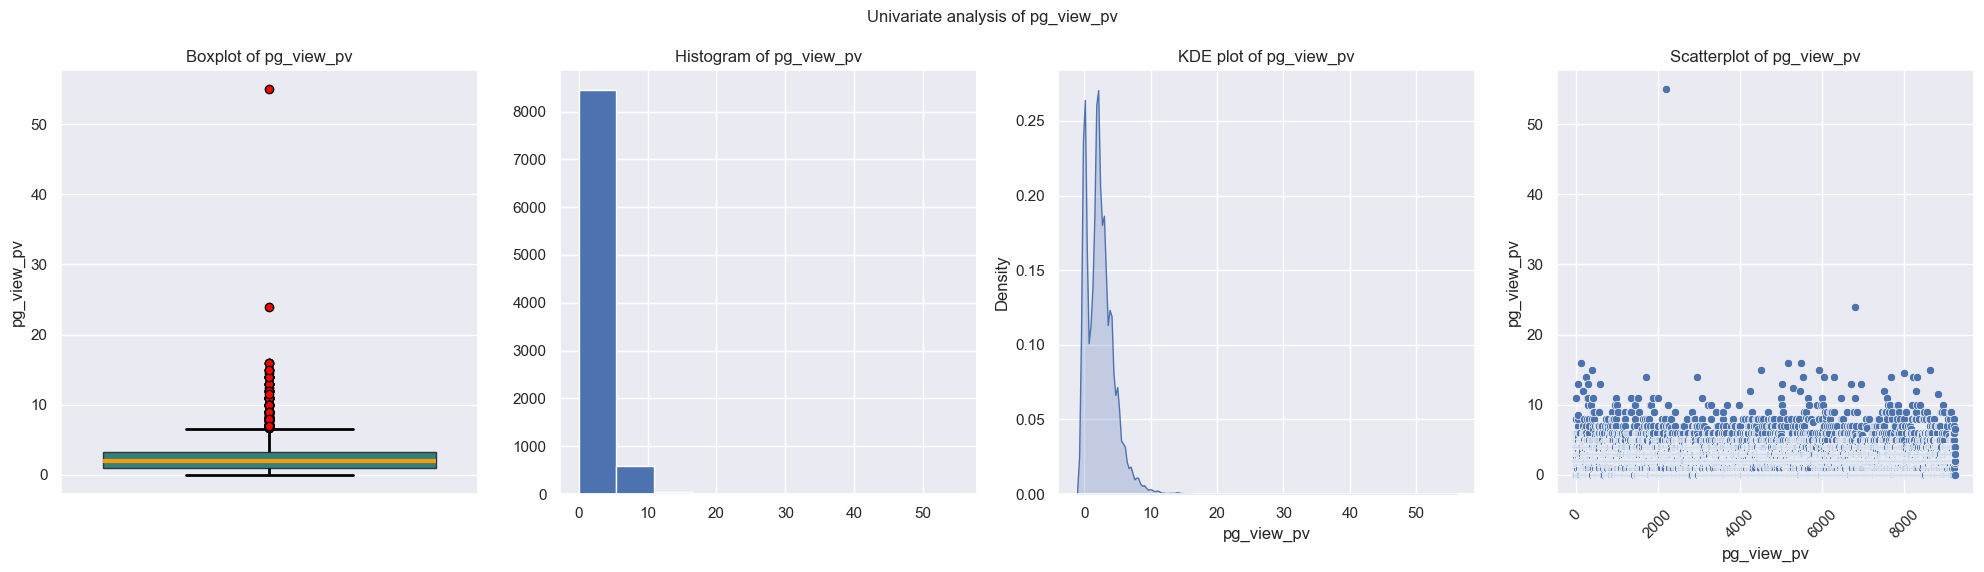

<Figure size 640x480 with 0 Axes>

In [30]:
# univariate plots#
# Now we perform Univariate analysis on both categorical and numerical variables
dtype_dict = classify_feature_dtype(lead_score_df, lead_score_df.columns )
univariate_plots(lead_score_df, dtype_dict['float_ts'], ftype='non_categorical', target='converted')

#####  Observations

- The converter column has more ones than zeros
- The box plot for total visits shows that there are outliers and the majority of the total visits fall between 0 and 30
- The box plot for page view per visit shows that there are outliers majority of them fall between 0 and 20

#####

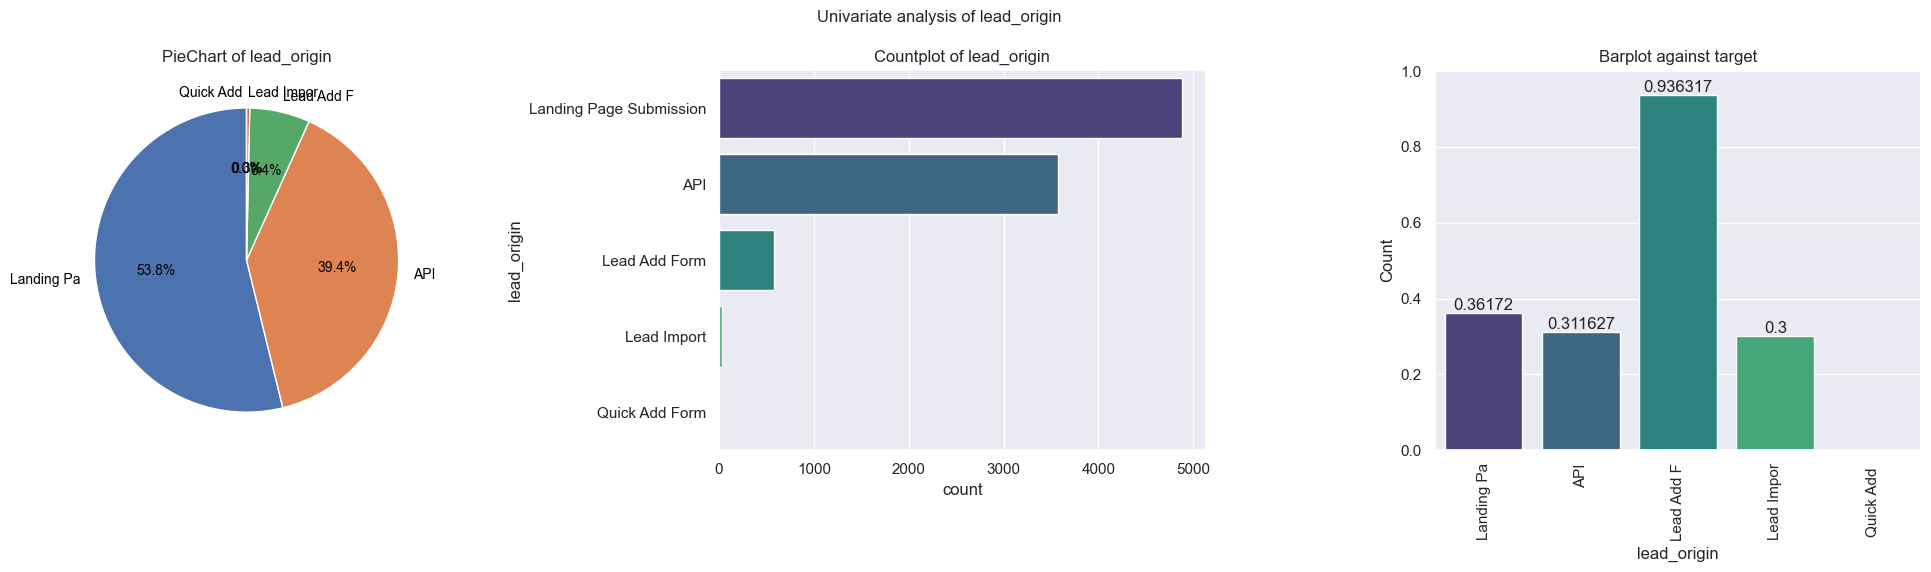

<Figure size 640x480 with 0 Axes>

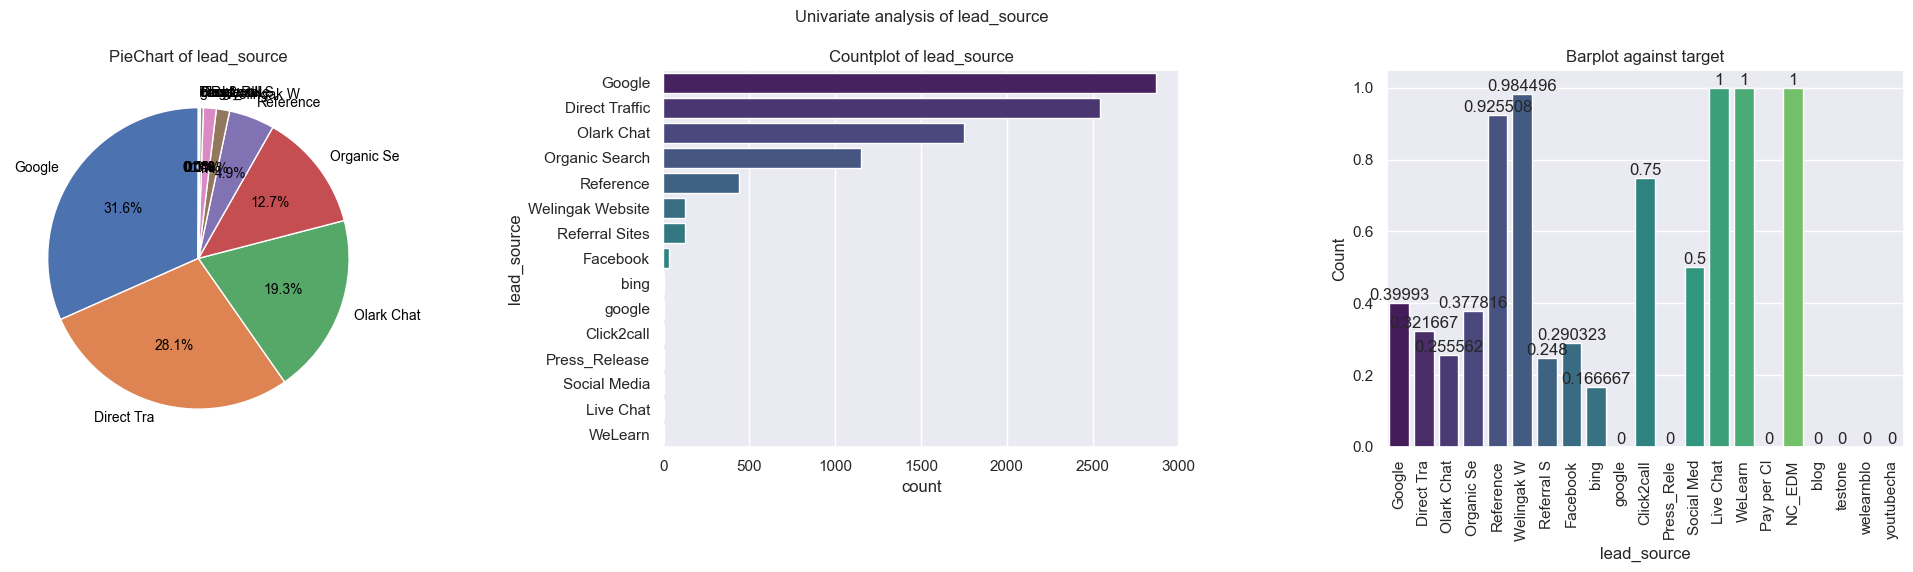

<Figure size 640x480 with 0 Axes>

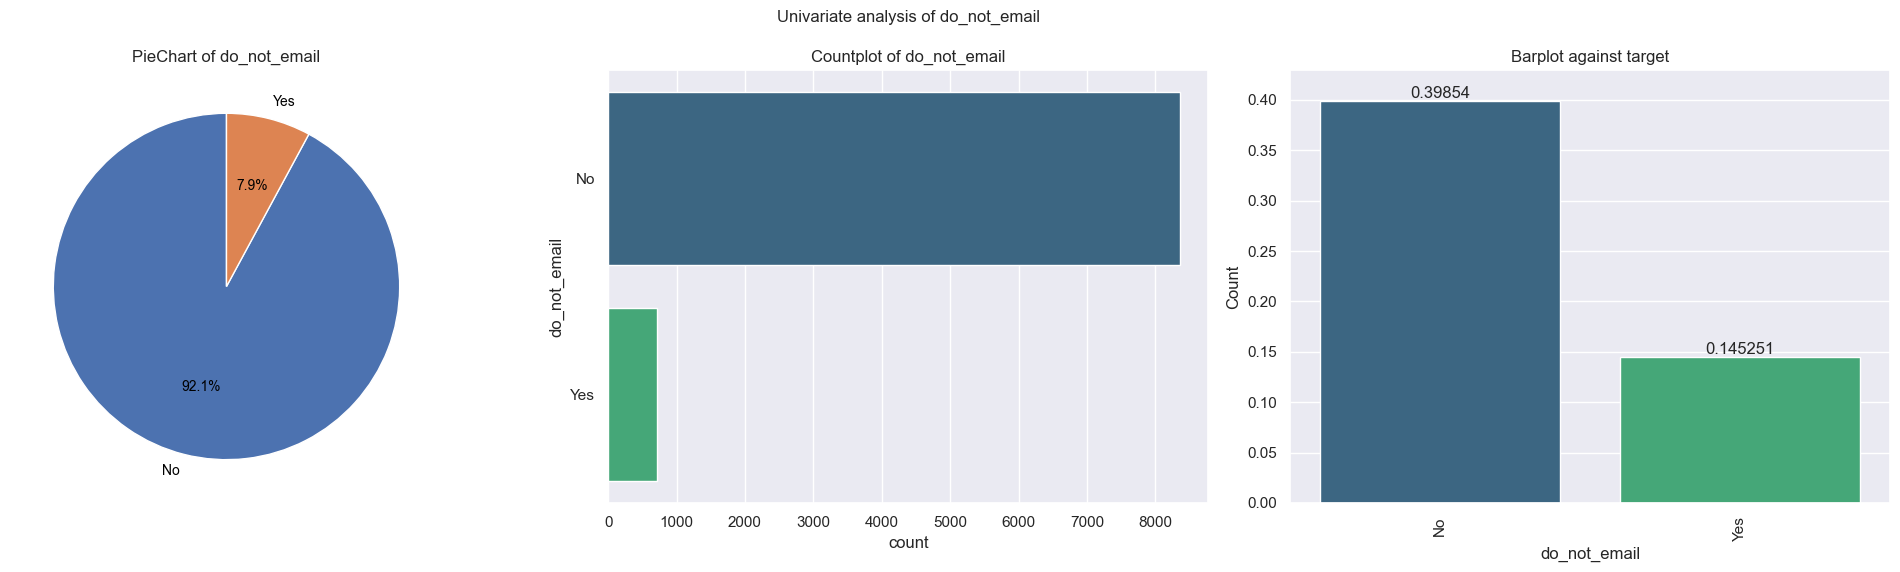

<Figure size 640x480 with 0 Axes>

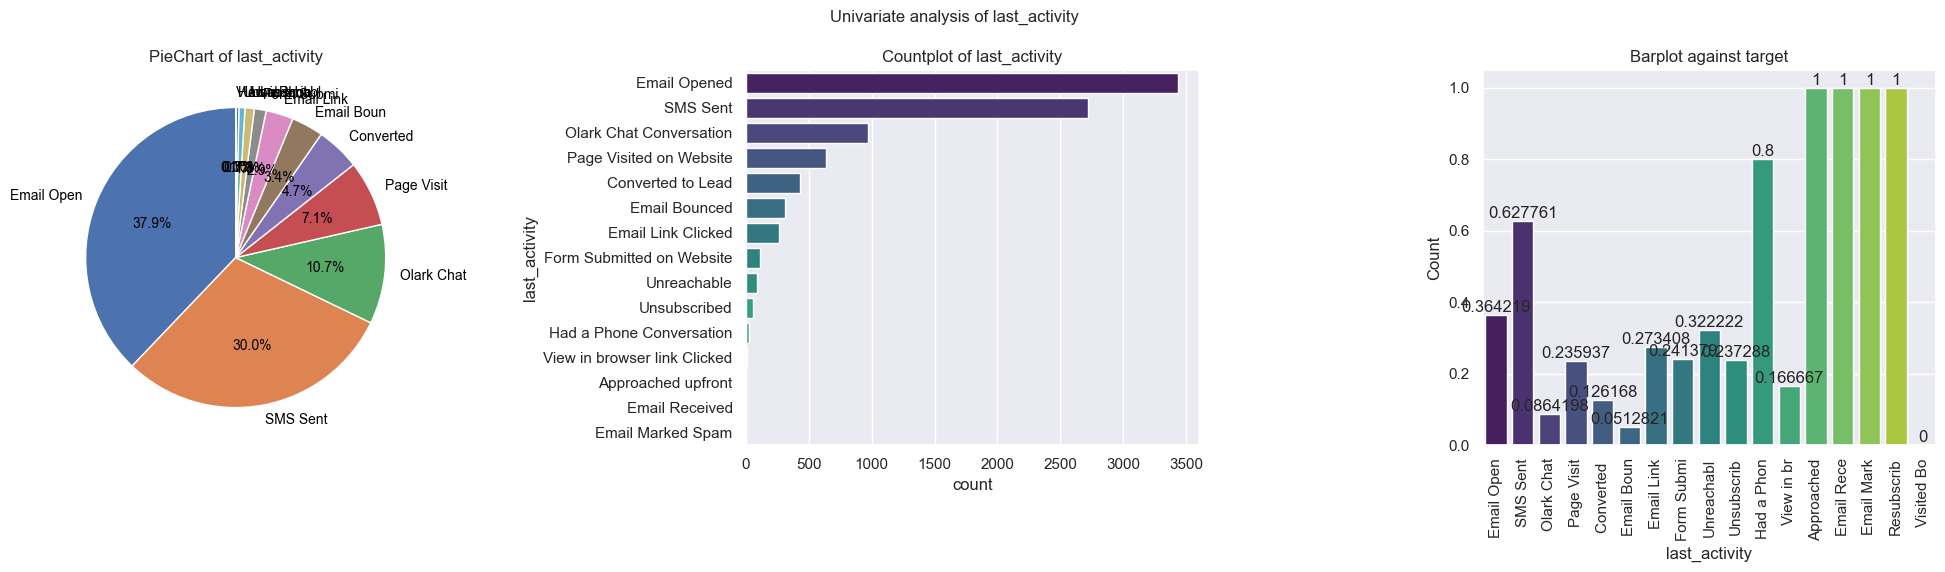

<Figure size 640x480 with 0 Axes>

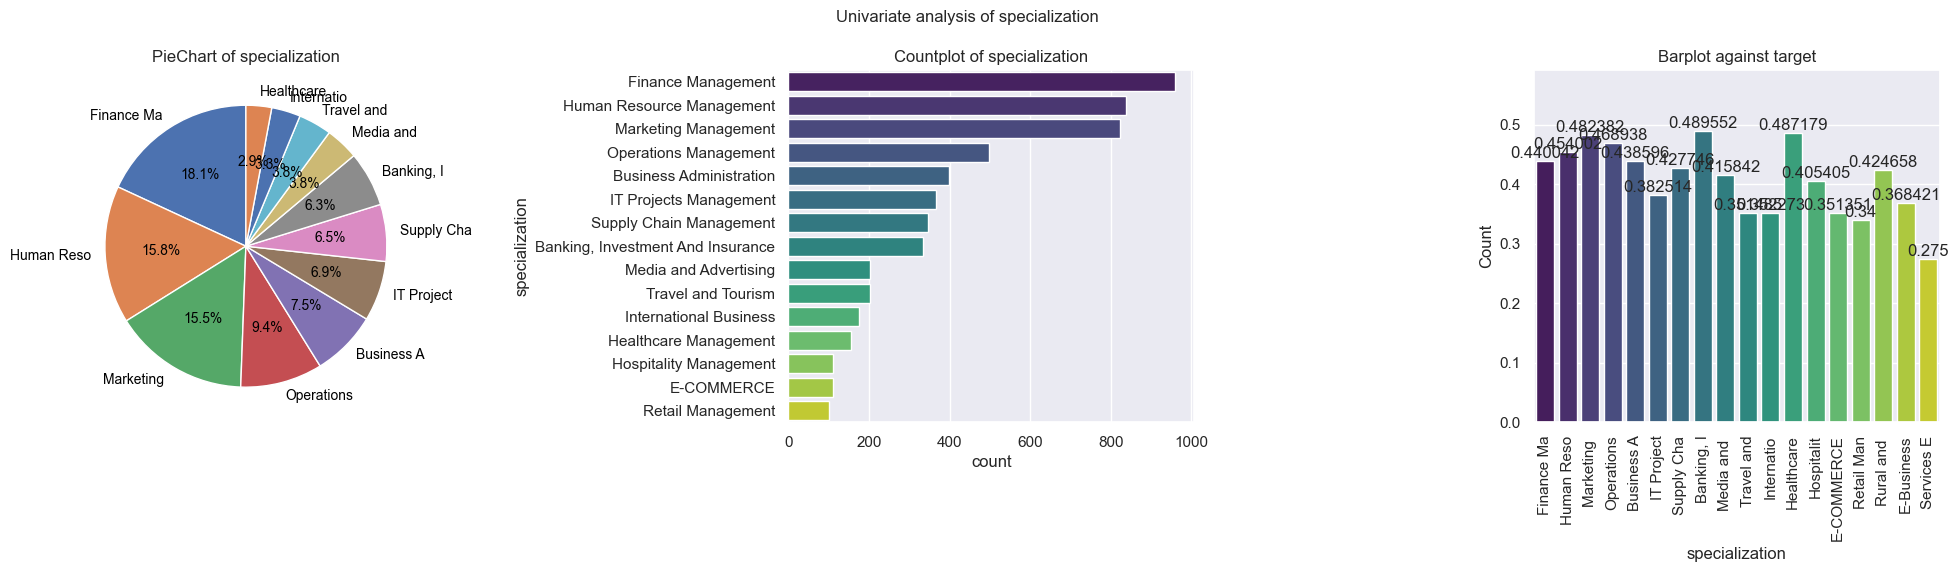

<Figure size 640x480 with 0 Axes>

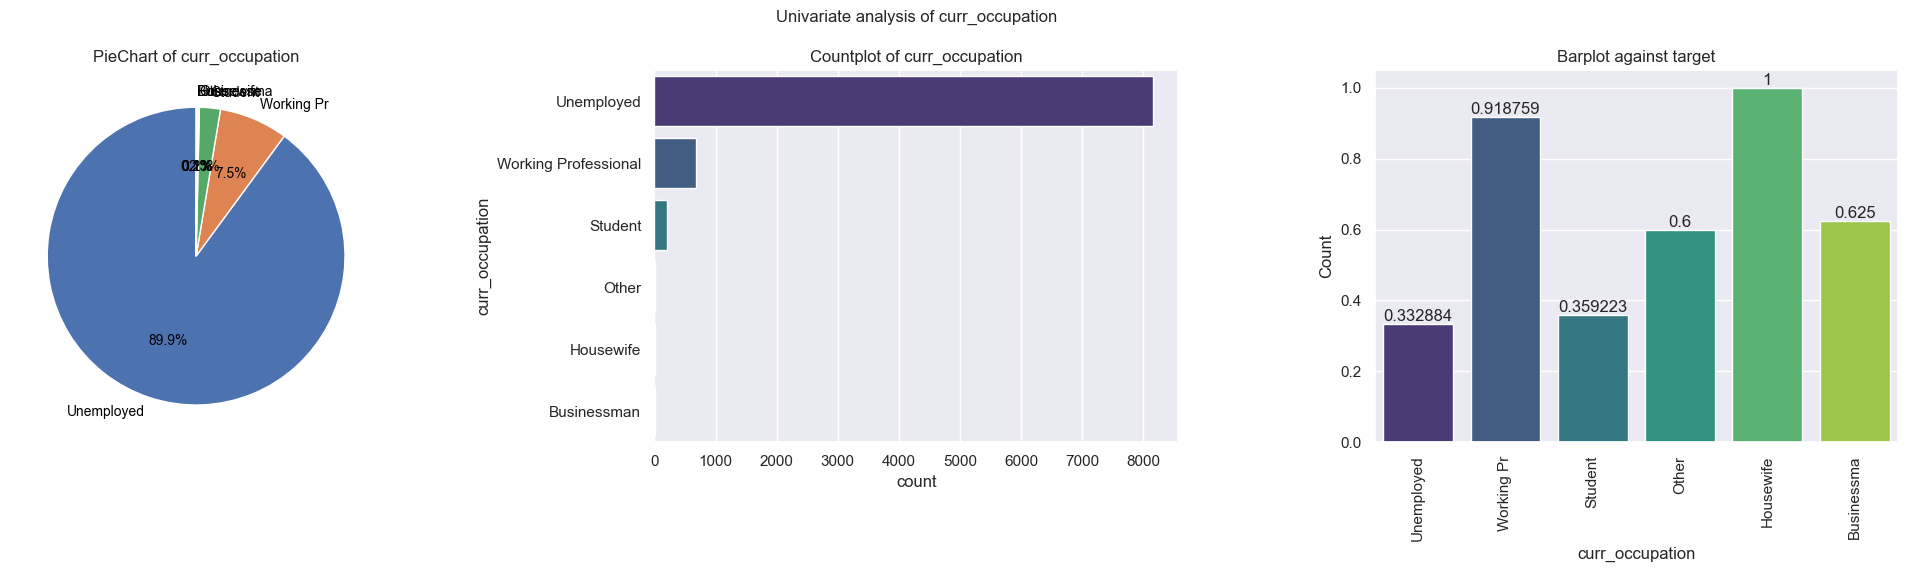

<Figure size 640x480 with 0 Axes>

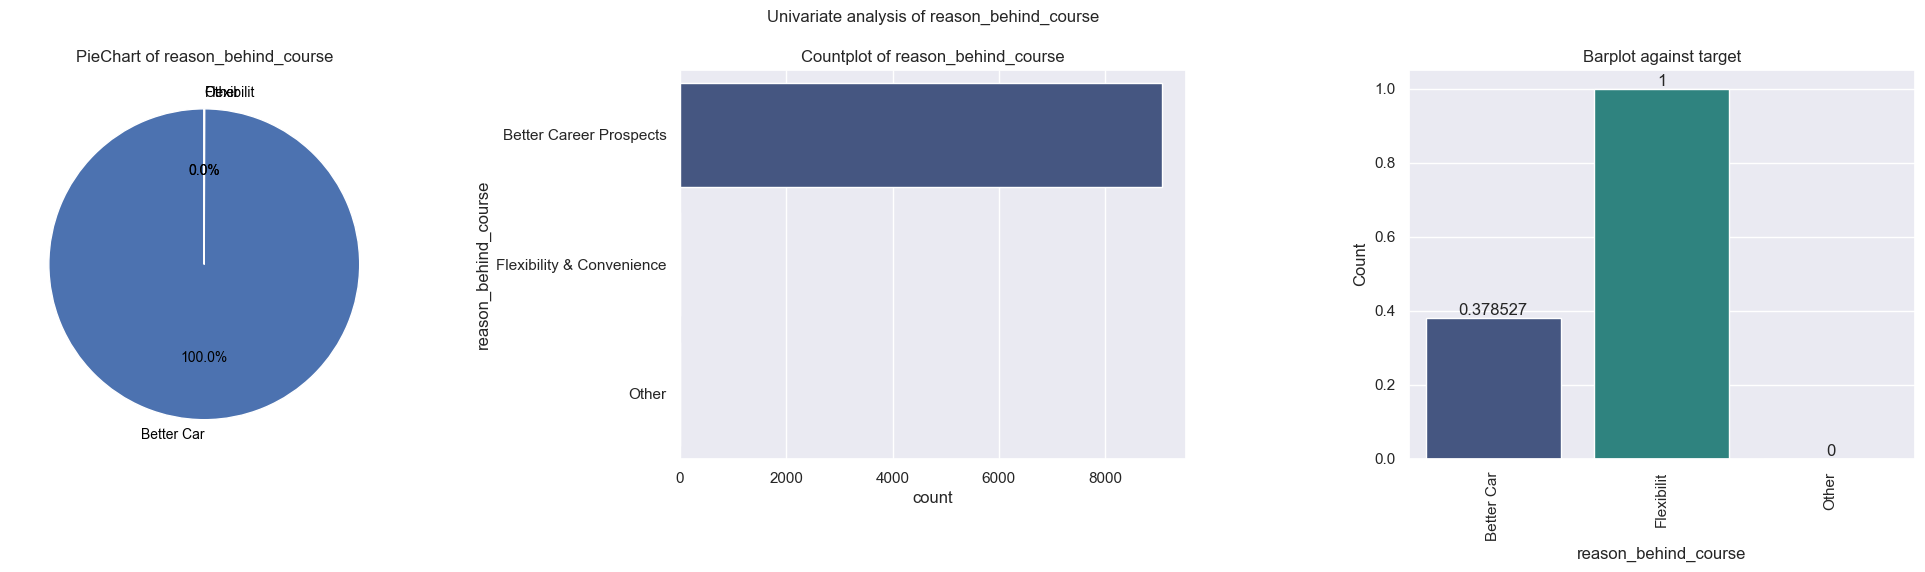

<Figure size 640x480 with 0 Axes>

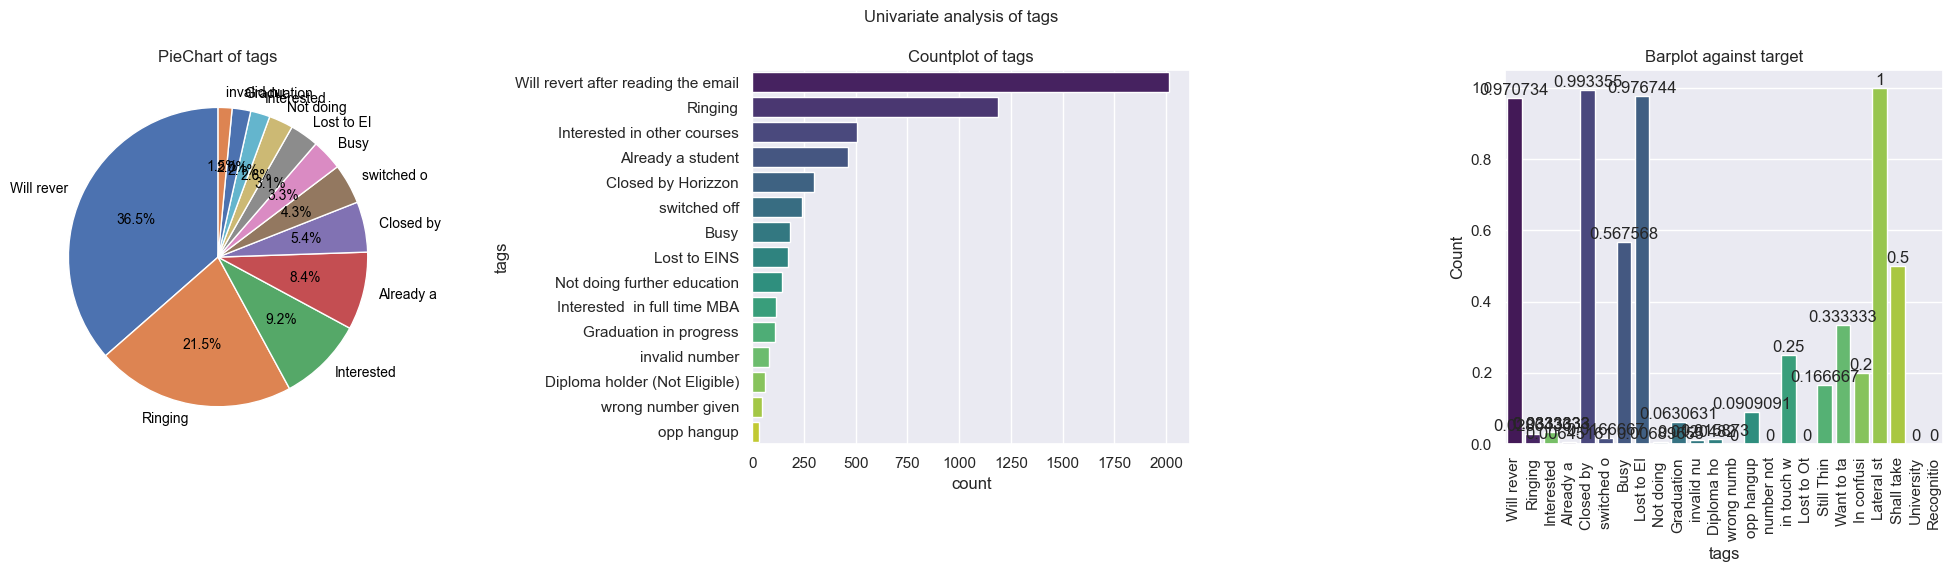

<Figure size 640x480 with 0 Axes>

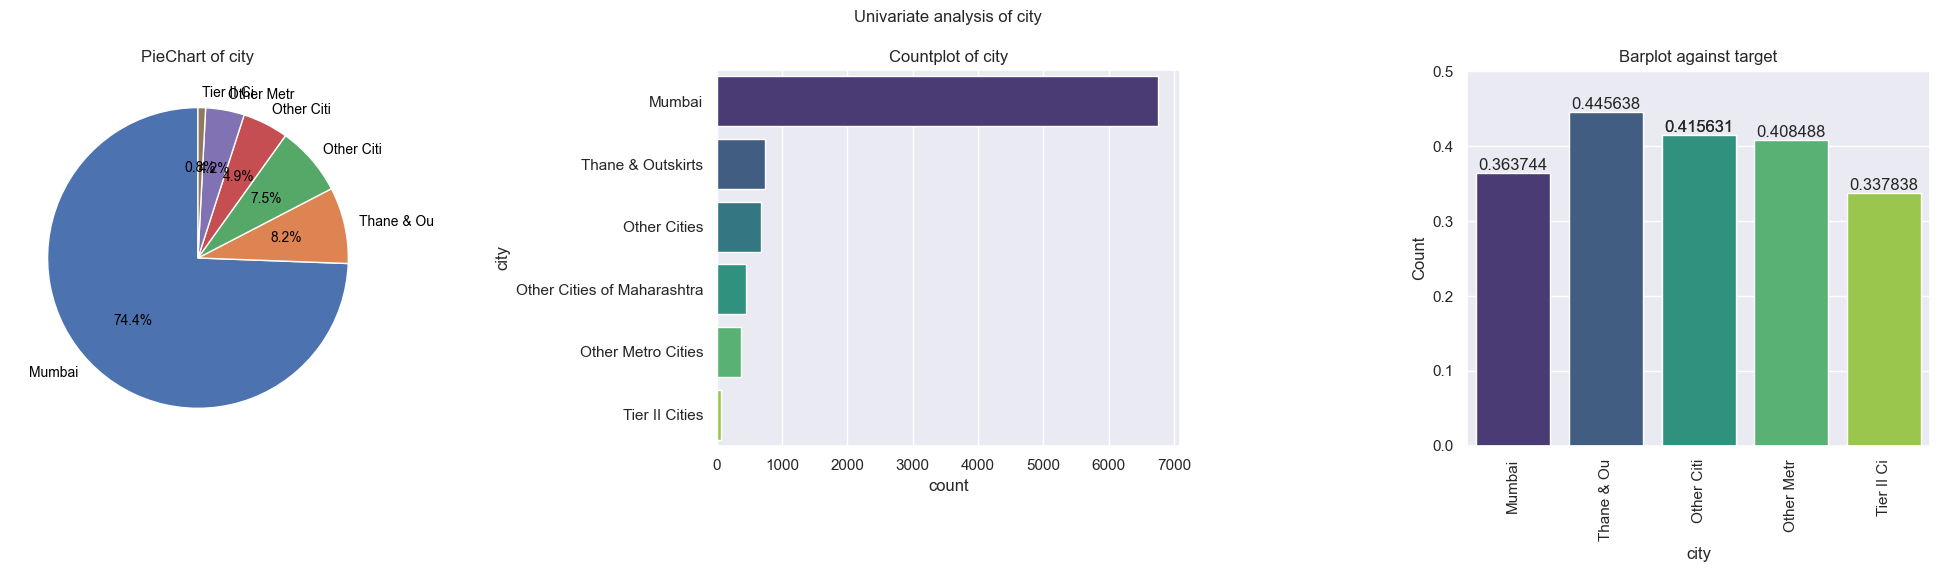

<Figure size 640x480 with 0 Axes>

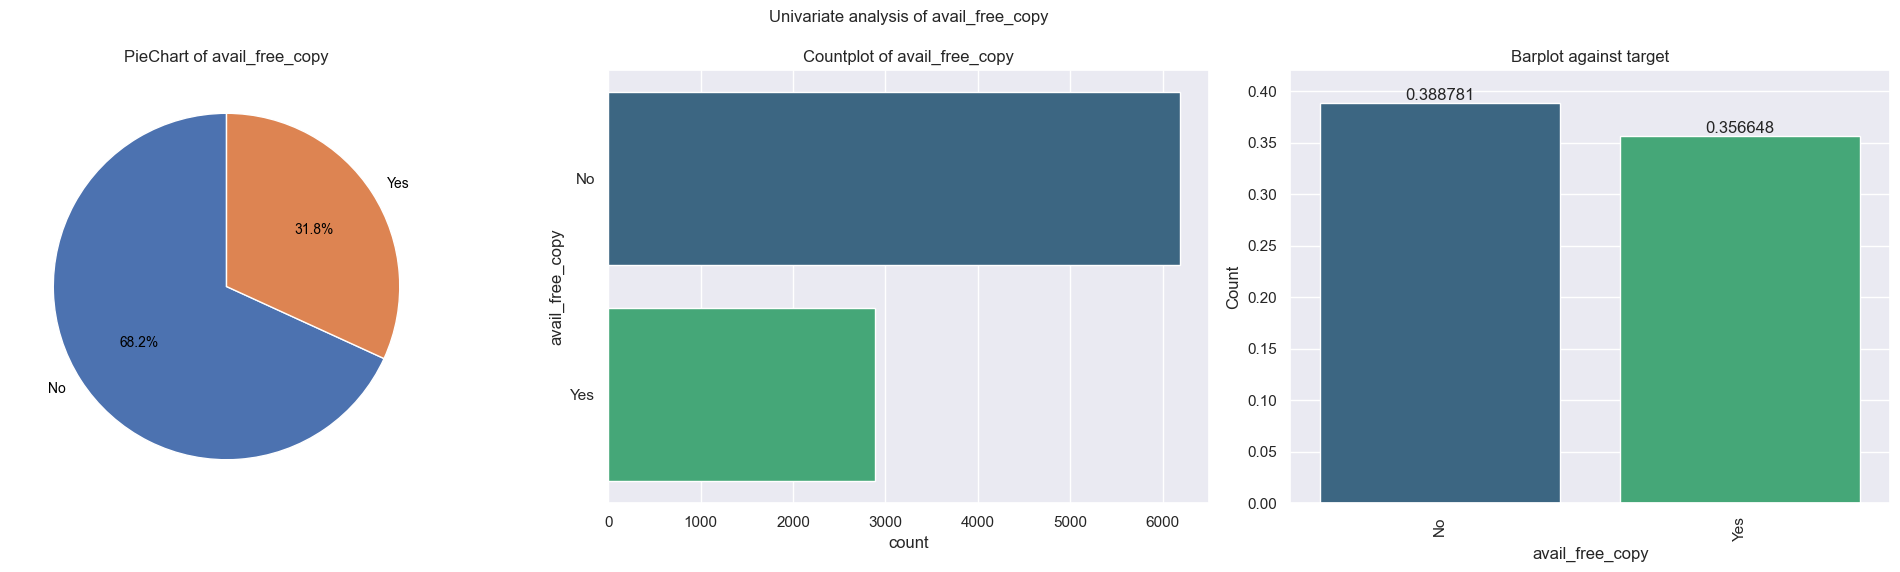

<Figure size 640x480 with 0 Axes>

In [31]:
# univariate plots
cols = dtype_dict['int_cat'].copy()
cols.remove('converted')
univariate_plots(lead_score_df, cols, ftype='categorical', target='converted')

####  Observations

##### The categorical analysis
 - More than 50 per cent of the users are by originated landing page following which the apis have 38 of leeds
 - When it comes to lead origin conversion rates lead add form has higher conversion rates holistically all have similar probability rate
 
 - When it comes to lead source 30 are from google twenty seven percent are from direct traffic 19 are from olak chat
 
 - For the do not email feature 90 of them chose no while 7 of them chose yes therefore majority of them are interested in the edtech platform
 - Also the people who have said no also the users who said no have a higher percent of conversion rate
  
 - The last activity of majority of the users say 38 of users are email opened followed by sms sent therefore we can say that
 - Majority of the users are active on email conversations
  
 - Majority of the users are from india
 - We can we can assume that air tech has a higher popularity in india or higher interest in india higher demand in india
 
 - Among the employed users most of the interested users have finance management as a specialization followed by human resource management and marketing management almost all specialization has a similar conversion rate
 
 - Majority of the users are unemployed followed by working professionals
 - Working professionals have a higher conversion rates while the user count is low in comparison to unemployed
  
 - Majority of the users have chosen better career prospects as a reason for opting for the course
 
 - The majority of the leads have been tagged under will revert after reading the email
 
 - Maximum number of leads have been from the city of mumbai followed by thane almost all categories have similar probabilities of conversion
  
 - 90 of the leads have opted not to free copy of the interview while 31 are opted for interview copy
 

####

In [ ]:
# Bivariate plots
# The pair plot view shows that there is a slight correlation between total visits and page view per visit
sns.pairplot(lead_score_df)
plt.show();

In [ ]:
# multivariate plots
# The heat map shows that majority of the features have no correlation or has lesser than 0 5 correlation

plt.figure(figsize = (20, 4)) # Size of the figure
sns.heatmap(lead_score_df.select_dtypes(exclude='category').corr(), annot = True)
plt.show();

##### ----

In [ ]:
errorline # do not delete

#### 3.1 Other Bivariate - Multivariate plots (computationally intensive)

In [ ]:
# # Boxplots - numerical features against target

axs = 141
plt.figure(figsize=(26, 6))
for i in list(set(dtype_dict['float_ts']) - set(['date','converted','lead_number'])):
    plt.subplot(axs)
    sns.boxplot(y=i, x='converted', data=lead_score_df, palette='tab10')
    axs += 1
plt.show();

In [ ]:
# # Generate Bivariate Boxplots combinations for all the categorical vs continuous columns

x_lst = list(dtype_dict['int_cat']) # x_list variable contains all the categorical Columns 
y_lst = list(dtype_dict['float_ts'])# y_list contains all Continuous feature type columns 
axs = 1
for x_col in x_lst:
    plt.figure(figsize=(26,72))
    for y_col in y_lst:
        plt.subplot(18,4,axs)
        sns.boxplot(x=x_col, y=y_col, data=lead_score_df, palette='tab10')
        plt.xticks(rotation=90)
        axs += 1
    plt.show();
plt.show();

In [ ]:
# # Generate Bivariate Barplots combinations for all the categorical features

mplib.rcParams['ytick.labelsize'] = 8
mplib.rcParams['xtick.labelsize'] = 8

y_lst = x_lst = list(set(dtype_dict['int_cat']) - set(['converted','lead_number'])) # x_list variable contains all the categorical Columns 
axs = 1
for x_col in x_lst:
    plt.figure(figsize=(25,400))
    for y_col in y_lst:
        
        # x_f = lead_score_df[x_col]
        # y_f = lead_score_df[y_col]
            
        # if isinstance(x_f,(object,'category')):
        #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
        # if isinstance(y_f,(object,'category')):
        #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
        
        plt.subplot(60,4,axs)
        sns.barplot(x=x_col, y=y_col, hue ='converted' ,data=lead_score_df, palette='tab10')
        plt.xticks(rotation=90)
        # plt.ylabel(ylabel= lead_score_df[y_col].name, labelpad=-50)
        # plt.locator_params(tight=True)
        axs += 1
    plt.show();
    axs = 1
plt.show();

In [ ]:
# # Multivariate Boxplots  - 

mplib.rcParams['ytick.labelsize'] = 8
mplib.rcParams['xtick.labelsize'] = 8
# mplib.rcParams['ytick.major.size'] = 2
# mplib.rcParams['xtick.major.size'] = 2

z_lst = x_lst = list(dtype_dict['int_cat'])
y_lst = list(dtype_dict['float_ts'])
y_lst.remove('lead_number')
axs = 1
for x_col in x_lst:
    for y_col in y_lst:
        plt.figure(figsize=(25, 200))
        for z_col in z_lst:
            
            # x_f = lead_score_df[x_col]
            # y_f = lead_score_df[y_col]
            
            # if isinstance(x_f,(object,'category')):
            #     x_f = x_f.astype('str',copy=True).str.slice(0,10)
            # if isinstance(y_f,(object,'category')):
            #     y_f = y_f.astype('str',copy=True).str.slice(0,10)
            
            plt.subplot(25, 2, axs)
            sns.boxplot(x=x_col, y=y_col, hue=z_col,hue_order=lead_score_df[z_col].value_counts().head(10).index ,data=lead_score_df, palette='tab10')
            plt.xticks(rotation=90)
            # plt.locator_params(tight=True)
            plt.legend(loc='best')
            axs += 1
        plt.show();
    axs = 1
    print("--------------------------------------------------------------------------")
    # break
plt.show();

In [ ]:
# # Multivariate Boxplots  - 

mplib.rcParams['ytick.labelsize'] = 8
mplib.rcParams['xtick.labelsize'] = 8
# mplib.rcParams['ytick.major.size'] = 2
# mplib.rcParams['xtick.major.size'] = 2

x_lst = list(dtype_dict['int_cat'])
x_lst.remove('lead_origin')
x_lst.remove('converted')
z_lst = y_lst= x_lst
axs = 1
for x_col in x_lst:
    for y_col in y_lst:
            plt.figure(figsize=(25, 500))
            for z_col in z_lst:
                 if (x_col != y_col) & (y_col != z_col) & (x_col != z_col):
                         
                #     x_f = lead_score_df[x_col]
                #     y_f = lead_score_df[y_col]
                #     if isinstance(x_f,(object,'category')):
                #             x_f = x_f.astype('str',copy=True).str.slice(0,10)
                #     if isinstance(y_f,(object,'category')):
                #             y_f = y_f.astype('str',copy=True).str.slice(0,10)
                            
                    plt.subplot(100, 3, axs)
                    sns.barplot(x=x_col, y=y_col, hue=z_col, hue_order=lead_score_df[z_col].value_counts().head(10).index, data=lead_score_df, palette='tab10')
                    plt.xticks(rotation=90)
                #     plt.ylabel(labelpad=3)
                #     plt.locator_params.set_label_coords(-0.01, 0.5)
                    plt.legend(loc='best')
                    axs += 1
            plt.show()
            axs = 1
    print("--------------------------------------------------------------------------")
plt.show();

###  ----------------------------------------------------------------------

### 4. Data Preprocesing - Part 2

#### Outlier Analysis and Capping

In [ ]:
# After performing eda we identified outliers in page view per visit totalvisits ttime on site columns we therefore cap all the values to the upper cut off and lower cut off of the iqr range

ex_val_df = get_extremeval_threshld(df=lead_score_df.select_dtypes(exclude=['category','object']) )
ex_val_df
lead_score_df.describe(percentiles=[.05,.1,.2,.5,.8,.9])

In [ ]:
# Fix Outliers by setting either thresh low or thresh low for both extremes 
lower_cutoff = ex_val_df.loc['pg_view_pv','thresh_low']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] < lower_cutoff), lower_cutoff, lead_score_df['pg_view_pv'])
upper_cutoff = ex_val_df.loc['pg_view_pv','thresh_high']
lead_score_df['pg_view_pv'] = np.where((lead_score_df['pg_view_pv'] > upper_cutoff), upper_cutoff, lead_score_df['pg_view_pv'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['totalvisits','thresh_low']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] < lower_cutoff), lower_cutoff, lead_score_df['totalvisits'])
upper_cutoff = ex_val_df.loc['totalvisits','thresh_high']
lead_score_df['totalvisits'] = np.where((lead_score_df['totalvisits'] > upper_cutoff), upper_cutoff, lead_score_df['totalvisits'])

# Fix Outliers by setting either thresh low or thresh low for both extremes
lower_cutoff = ex_val_df.loc['ttime_on_site','thresh_low']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] < lower_cutoff), lower_cutoff, lead_score_df['ttime_on_site'])
upper_cutoff = ex_val_df.loc['ttime_on_site','thresh_high']
lead_score_df['ttime_on_site'] = np.where((lead_score_df['ttime_on_site'] > upper_cutoff), upper_cutoff, lead_score_df['ttime_on_site'])

In [ ]:
lead_score_df.describe()

In [ ]:
# Additionally there are few null values in their total visits and page view pub features therefore we replace with the mean of that particular column

lead_score_df['totalvisits'] = lead_score_df['totalvisits'].replace(to_replace=np.nan, value=lead_score_df['totalvisits'].mean())
lead_score_df['pg_view_pv'] = lead_score_df['pg_view_pv'].replace(to_replace=np.nan, value=lead_score_df['pg_view_pv'].mean())

In [ ]:
# replace Yes, No with 1 and 0
lead_score_df = lead_score_df.replace(to_replace=['Yes', 'No'], value=[1, 0])

In [ ]:
# our null values have significantly reduced
check_cols_null_pct(lead_score_df)
lead_score_df.shape

In [ ]:
lead_score_df.last_activity = lead_score_df.last_activity.fillna(lead_score_df.last_activity.mode()[0])
lead_score_df.last_activity.value_counts(normalize=True) * 100

lead_score_df.lead_source = lead_score_df.lead_source.fillna(lead_score_df.lead_source.mode()[0])
lead_score_df.lead_source.value_counts(normalize=True) * 100

In [ ]:
# lead_score_df.to_csv('spec_tag_analysis.csv')

lead_score_df = lead_score_df.drop(['specialization','tags'], axis=1)
check_cols_null_pct(lead_score_df)
lead_score_df.shape

In [ ]:
lead_score_df.dtypes

###  ----------------------------------------------------------------------

### 5. Data Imbalance & Conversion Ratio

In [ ]:
# Data Imbalance
# From the target variable we have found out the imbalance ratios around 62 therefore we decide not to rebalance

imbalance_ratio = sum(lead_score_df['converted'] == 1)/sum(lead_score_df['converted'] == 0) * 100
print(f'{round(imbalance_ratio, 2)}%')

In [ ]:
# Conversion Ratio 
# From the target variable the conversion ratio is around 38 it shows that there is a very high probability of failure in conversion

converted = (sum(lead_score_df['converted'])/len(lead_score_df['converted'].index))*100
print(f'{round(converted, 2)}%')

##  -----------------------------------------------------

In [ ]:
errorline # do no remove this line

## -----------------------------------------------------

## Approach - 01

### Data Encoding

#### Dummy Encoding

In [ ]:
#  we perform dummy encoding
new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns, drop_first=True, dtype=float)
new_ls_df.head(1)

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = new_ls_df.drop(['lead_number','converted'], axis=1)
y = new_ls_df['converted']

In [ ]:
# Now we split the dataset into train and test set
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
new_ls_df.dtypes

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(X.columns)
to_scale

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

##### Model 2

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

##### Model 3

In [ ]:
col = col.drop('curr_occupation_Housewife', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ---------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

In [ ]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

## -----------------------------------------------------

In [ ]:
errorline # do no remove this line

## -----------------------------------------------------

## Approach - 02

### Data Encoding

#### Label Encoding

In [ ]:
# for label_encoding:
# Since there are many categorical features with nominal values 5 we decide to use label encoding for those features

cols_to_le = [i for i in lead_score_df.columns if ((lead_score_df[i].dtype == 'category') and len(lead_score_df[i].unique()) > 5)]
cols_to_le

In [ ]:
le = LabelEncoder()
df_le = lead_score_df[cols_to_le].apply(le.fit_transform)

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_le.corr(), annot=True)

In [ ]:
# We then merged the encoder features with the non encoded features and name it as new lsdf

new_ls_df = lead_score_df[lead_score_df.columns.difference(cols_to_le)]
new_ls_df = new_ls_df.merge(right=df_le, right_index=True, left_index=True)
new_ls_df.head()

In [ ]:
# our null values have significantly reduced
check_cols_null_pct(new_ls_df)
new_ls_df.shape

In [ ]:
# new_ls_df = new_ls_df[(new_ls_df.notna()).all(axis=1)]
# check_cols_null_pct(new_ls_df)
# sorted([f'{i} - {new_ls_df[i].unique()}' for i in new_ls_df.columns])

#### Dummy Encoding

In [ ]:
# for label_encoding:
# For those columns that are lesser than 5 labels we perform dummy ecoding

cols_to_de = [i for i in new_ls_df.columns if ((new_ls_df[i].dtype == 'category') and len(new_ls_df[i].unique()) <= 5)]
cols_to_de
new_ls_df = pd.get_dummies(new_ls_df, columns=cols_to_de, drop_first=True, dtype=float)

In [ ]:
new_ls_df.head(1)

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = new_ls_df.drop(['converted'], axis=1)
y = new_ls_df['converted']

In [ ]:
# Now we split the dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv', 'lead_source', 'last_activity', 'country', 'curr_occupation']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features

logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

##### Model 2

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

##### Model 3

In [ ]:
col = col.drop('lead_origin_Quick Add Form', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 4

In [ ]:
col = col.drop('reason_behind_course_Other')
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:


##### Model 5

In [ ]:
col = col.drop('avail_free_copy_1')
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

##### Model 6

In [ ]:
col = col.drop('lead_origin_Lead Import')
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


##### Model 7

In [ ]:
col = col.drop('reason_behind_course_Flexibility & Convenience')
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:


####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

####  ----------------------------------------------------------------------

#### ROC Curve and Precision - Recall Curve

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

In [ ]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

## -----------------------------------------------------

In [ ]:
errorline # do no remove this line

## -----------------------------------------------------

## Approach - 03

### Data Encoding

#### Dummy Encoding

In [ ]:
#  we perform dummy encoding

new_ls_df = pd.get_dummies(lead_score_df, columns=lead_score_df.select_dtypes('category').columns, drop_first=True, dtype=float)
new_ls_df.head(1)

###  ----------------------------------------------------------------------

### Train and Test Split

In [ ]:
X = new_ls_df.drop(['lead_number','converted'], axis=1)
y = new_ls_df['converted']

In [ ]:
# Now we split the dataset into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

###  ----------------------------------------------------------------------

### Feature Scaling

In [ ]:
new_ls_df.dtypes

In [ ]:
# Post split we perform standard scaling they fit and transform the train data set

# to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']
to_scale = list(set(list(X.columns)) - set(['totalvisits','ttime_on_site','pg_view_pv']))
to_scale

scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale], y_train)
X_train.head()

###  ----------------------------------------------------------------------

### Model Building

##### Custom Functions for Model Training

In [ ]:
# We create custom functions for model veiling since iteration we reuse certain functions again and again
# Train and predict function trains the model and predicts on the same data and returns the model its probability and predicted values based on cutoff
# The matrix function returns confusion matrix and accuracy score
# The vif function returns the vif score for the features

def logreg_train_pred_fn(fX_train, fy_train, fcol, fcutoff):
    fX_train_sm = sm.add_constant(fX_train[fcol])
    flogm = sm.GLM(fy_train, fX_train_sm, family = sm.families.Binomial())
    fres = flogm.fit()
    fy_train_pred = fres.predict(fX_train_sm)
    fy_train_pred = fy_train_pred.values.reshape(-1)
    fy_train_pred_final = pd.DataFrame({'Converted':fy_train.values, 'Conv_Prob':fy_train_pred})
    fy_train_pred_final['ID'] = fy_train.index
    fy_train_pred_final['predicted'] = fy_train_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_train_pred,fy_train_pred_final

def logreg_metrics_fn(fy_train_pred_final):
    fconfusion = confusion_matrix(fy_train_pred_final.Converted, fy_train_pred_final.predicted )
    faccuracy = accuracy_score(fy_train_pred_final.Converted, fy_train_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_VIF_score_fn(fX_train, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_train[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_train[fcol].values, i) for i in range(fX_train[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

##### Base Model 1

In [ ]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
res.summary()

##### RFE - Recursive Feature Elimination

In [ ]:
# Since the data set has a lot of features we perform rfe to eliminate insignificant features
logreg = LogisticRegression()

rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

##### Model 2

In [ ]:
# Now we perform model iteration as many times as possible till we get an optimum result

cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')       # Accuracy Score:

##### Model 3

In [ ]:
col = col.drop('curr_occupation_Housewife', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 4

In [ ]:
col = col.drop('country_Canada', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 5

In [ ]:
col = col.drop('country_Qatar', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

##### Model 6

In [ ]:
col = col.drop('last_activity_Email Marked Spam', 1)
col

In [ ]:
cutoff = 0.5
res, y_train_pred,y_train_pred_final = logreg_train_pred_fn(X_train, y_train, col, cutoff)
confusion, accuracy = logreg_metrics_fn(y_train_pred_final)
vif = logreg_VIF_score_fn(X_train, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif

In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_train_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_train_pred_final
print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')   # Accuracy Score:

####  ----------------------------------------------------------------------

#### Finding Optimal Cutoff Point

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

In [ ]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion

#### ROC Curve and Precision - Recall Curve

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)

In [ ]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
plt.plot(thresholds, p[:-1], "b")
plt.plot(thresholds, r[:-1], "r")
plt.title('Precision Recall Curve')
plt.show();

###  ----------------------------------------------------------------------

### Predictions on the test set

##### Custom Functions for Test

In [ ]:
def logreg_test_pred_fn(fX_test, fy_test, fcol, fcutoff, fres):
    fX_test_sm = sm.add_constant(fX_test[fcol])
    fy_test_pred = fres.predict(fX_test_sm)
    fy_test_pred = fy_test_pred.values.reshape(-1)
    fy_test_pred_final = pd.DataFrame({'Converted':fy_test.values, 'Conv_Prob':fy_test_pred})
    fy_test_pred_final['ID'] = fy_test.index
    fy_test_pred_final['predicted'] = fy_test_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return fres, fy_test_pred,fy_test_pred_final

def logreg_test_metrics_fn(fy_test_pred_final):
    fconfusion = confusion_matrix(fy_test_pred_final.Converted, fy_test_pred_final.predicted )
    faccuracy = accuracy_score(fy_test_pred_final.Converted, fy_test_pred_final.predicted)
    return fconfusion, faccuracy
    
def logreg_test_VIF_score_fn(fX_test, fcol):
    fvif = pd.DataFrame()
    fvif['Features'] = fX_test[fcol].columns
    fvif['VIF'] = [variance_inflation_factor(fX_test[fcol].values, i) for i in range(fX_test[fcol].shape[1])]
    fvif['VIF'] = round(fvif['VIF'], 2)
    fvif = fvif.sort_values(by = "VIF", ascending = False)
    return fvif

#### Model Validation on Test Data

In [ ]:
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_test[col].head()

In [ ]:
cutoff = 0.3
res, y_test_pred, y_test_pred_final = logreg_test_pred_fn(X_test, y_test, col, cutoff, res)
confusion, accuracy = logreg_test_metrics_fn(y_test_pred_final)
vif = logreg_test_VIF_score_fn(X_test, col)

print('Model Summary:')          # Model Summary:
res.summary()
print('\nVIF Score:')            # VIF Score:
vif


In [ ]:
# print('\nY_Predicted Values:')   # Y_Predicted Values:
# y_test_pred
# print('\nY_Predicted Cutoff:')   # Y_Predicted Cutoff:
# y_test_pred_final

print('\nConfusion Matrix:')     # Confusion Matrix: 
confusion
print(f'\nAccuracy Score: {accuracy}\n')  # Accuracy Score:

## ------------------------------------------------------

In [ ]:
errorline # do no remove this line

## ------------------------------------------------------

##  Approach - 04

In [ ]:
# new_ls_df 
lead_score_df.isna().sum()

## ------------------------------------------------------